## There is no ML here

***

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise

In [2]:
# ~3.5s
# Reading data for version 1

de_train = pd.read_parquet("C:\Личные документы\data\single_cell\de_train.parquet")
id_map = pd.read_csv("C:\Личные документы\data\single_cell\id_map.csv")
sample_submission = pd.read_csv("C:\Личные документы\data\single_cell\sample_submission.csv")

![version 1](version_1.png)

***

## Version 1.0 - 0.627

Наивный прогноз - просто заполняем средним значение DE для каждого гена полученом для клеток всех типов при воздействии определённого лекарства

In [3]:
# version 1.0
# public score = 0.627

gene_names = de_train.columns[5:]
sm_name = de_train.groupby('sm_name')[gene_names].mean().reset_index()
sample = id_map.merge(sm_name, on='sm_name', how='left')
sample = sample.drop(['cell_type', 'sm_name'], axis=1)
sample.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,1,-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,2,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,3,-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,4,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
251,251,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
252,252,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
253,253,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


*** 
## Version 1.1 - 0.7

Чуть-чуть уточнённый наивный прогноз:

1. Определим тип клеток который реагирует на лекарства максимально "похоже" на то как реагируют наши целевые клетки

2. Заменим таргеты на усреднённые показатели с "похожих" клеток

In [4]:
df = de_train.copy()
gene_names = de_train.columns[5:]
drugs = df[(df['cell_type'] == 'B cells') | (df['cell_type'] == 'Myeloid cells')]['sm_name'].unique()

lst_b = []
lst_m = []
for i in drugs:
    
    cosine = pairwise.cosine_similarity(df[df['sm_name'] == i][gene_names].values)

    cosine_df = pd.DataFrame(cosine, columns=df[df['sm_name'] == i]['cell_type'])

    cosine_df.iloc[0].sort_values()[[-1]]
    cosine_df.iloc[1].sort_values()[[-1]]
    lst_b.append(cosine_df.iloc[0].sort_values().index[-2])
    lst_m.append(cosine_df.iloc[1].sort_values().index[-2])
    
similarity = pd.DataFrame({'B cells':lst_b, 'Myeloid cells':lst_m}, index = drugs)

C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_10792\2114001864.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(similarity['B cells'].value_counts().index, rotation=60, horizontalalignment='right')
C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_10792\2114001864.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(similarity['Myeloid cells'].value_counts().index, rotation=60, horizontalalignment='right');


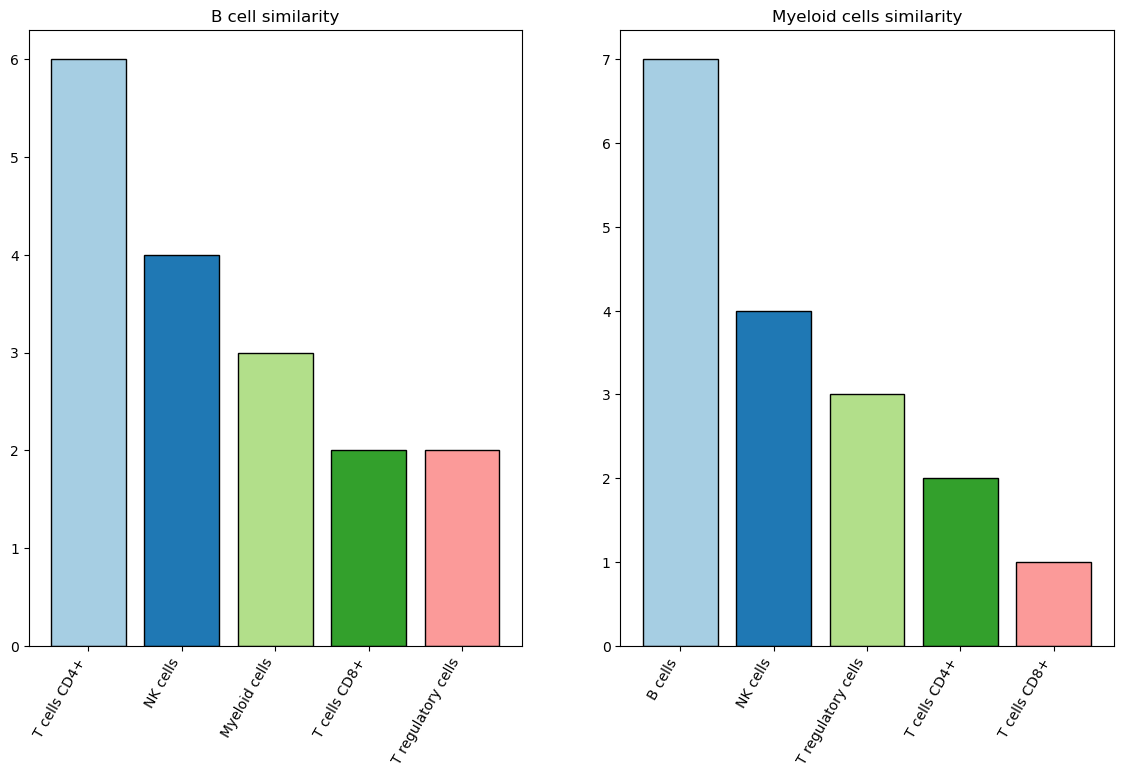

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
col_map = plt.get_cmap('Paired')

ax[0].bar(x=similarity['B cells'].value_counts().index, height=similarity['B cells'].value_counts().values, color=col_map.colors, edgecolor='k')
ax[0].set_title('B cell similarity')
ax[0].set_xticklabels(similarity['B cells'].value_counts().index, rotation=60, horizontalalignment='right')
ax[1].bar(x=similarity['Myeloid cells'].value_counts().index, height=similarity['Myeloid cells'].value_counts().values, color=col_map.colors, edgecolor='k')
ax[1].set_title('Myeloid cells similarity');
ax[1].set_xticklabels(similarity['Myeloid cells'].value_counts().index, rotation=60, horizontalalignment='right');

In [19]:
# все таргеты заменим на значения для T cells CD4+

sample = id_map.merge(df[df['cell_type'] == 'T cells CD4+'], on='sm_name', how='left')
sample = sample.drop(['cell_type_x', 'sm_name', 'cell_type_y', 'sm_lincs_id', 'SMILES', 'control'], axis=1)
sample.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.266457,0.111695,0.045063,0.160086,-0.041350,-0.120136,0.516555,-0.308187,-2.341003,...,-2.445495,-0.139079,-0.484845,0.547282,-0.130377,0.308918,0.373366,0.341637,-0.590761,1.063544
1,1,-0.365643,0.017510,0.408435,-0.035173,0.045939,0.237661,0.264575,-0.231776,0.729975,...,0.219543,-0.011157,0.486557,0.029518,-0.084958,-0.202668,-0.421331,0.449572,1.440663,-0.250461
2,2,0.211183,0.010452,-0.216173,-0.539276,0.179857,0.872006,1.822498,0.002999,0.620578,...,0.130556,-0.002238,0.037368,0.697363,0.075925,-0.181701,0.040686,-0.165730,-0.173773,0.017668
3,3,-0.574464,-0.022336,-0.136064,-0.730069,-1.213142,0.037384,-0.350129,-0.169643,-0.206428,...,0.268708,1.394378,0.031878,-0.326652,0.189602,0.829111,0.277501,0.776930,-0.012251,0.693199
4,4,0.549877,-0.526204,0.662430,-0.023341,-0.775132,0.215349,-0.476006,0.224587,-0.178200,...,-1.384302,0.305657,0.091574,-0.520839,0.012770,0.182982,-0.026352,0.281421,0.135921,-0.348825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,0.106623,0.006949,0.424472,-0.124439,1.123565,-0.086111,-0.172958,0.095781,0.032489,...,-0.053448,0.072833,-0.421440,0.067708,1.215890,0.226569,0.084715,-0.668755,0.798338,-0.060044
251,251,0.542029,-0.277948,-0.450695,0.006595,0.180319,0.675036,0.047667,0.115122,0.257481,...,-0.245188,0.567597,0.169583,0.742562,0.398926,0.073799,-0.543974,0.287531,0.104330,-0.042864
252,252,-0.035996,0.047872,-0.789347,0.085482,-0.035291,-0.081332,0.016032,-0.857765,-0.313521,...,-0.126685,0.806905,1.239159,0.592969,0.568535,-0.427910,-0.317065,0.209521,0.346017,-1.425032
253,253,-0.352723,-0.014036,-0.173234,-1.124086,-1.009963,-0.291678,1.418553,0.625217,3.089921,...,1.138463,1.707838,0.091151,-0.907728,-0.081602,-0.279920,-1.086152,0.460886,-0.189966,0.162542


*** 
## Version 1.2 - 0.7

In [25]:
drugs

array(['Idelalisib', 'Crizotinib', 'Linagliptin', 'Palbociclib',
       'Dabrafenib', 'Alvocidib', 'LDN 193189', 'R428',
       'Porcn Inhibitor III', 'Belinostat', 'Foretinib', 'MLN 2238',
       'Penfluridol', 'Dactolisib', 'O-Demethylated Adapalene',
       'Oprozomib (ONX 0912)', 'CHIR-99021'], dtype=object)

In [71]:
cells = df.loc[df['sm_name'] == drugs[0]].T.drop(['sm_name', 'sm_lincs_id', 'SMILES', 'control'], axis=0).iloc[0].values
DE = df.loc[df['sm_name'] == drugs[0]].T.drop(['sm_name', 'sm_lincs_id', 'SMILES', 'control', 'cell_type'], axis=0).values
data = pd.DataFrame(DE, columns=cells, index=gene_names)
X = data.drop(['B cells', 'Myeloid cells'], axis=1)
y_b = data['B cells']
y_m = data['Myeloid cells']

from sklearn.linear_model import LinearRegression
model_b = LinearRegression().fit(X, y_b)
model_m = LinearRegression().fit(X, y_m)

In [117]:
from sklearn.linear_model import LinearRegression

w_b = []
w_m = []

for i in np.arange(len(drugs)):
    cells = df.loc[df['sm_name'] == drugs[i]].T.drop(['sm_name', 'sm_lincs_id', 'SMILES', 'control'], axis=0).iloc[0].values
    DE = df.loc[df['sm_name'] == drugs[i]].T.drop(['sm_name', 'sm_lincs_id', 'SMILES', 'control', 'cell_type'], axis=0).values
    data = pd.DataFrame(DE, columns=cells, index=gene_names)
    X = data.drop(['B cells', 'Myeloid cells'], axis=1)
    y_b = data['B cells']
    y_m = data['Myeloid cells']

    model_b = LinearRegression().fit(X, y_b)
    model_m = LinearRegression().fit(X, y_m)
    
    w_b.append(model_b.coef_)
    w_m.append(model_m.coef_)
    
w_b = np.array(w_b, dtype=object)
w_m = np.array(w_m, dtype=object)
w_b = np.delete(w_b, [5, 15])
w_m = np.delete(w_m, [5, 15])

wb_df = pd.DataFrame({'B cell':w_b.mean(), 'Myeloid cells':w_m.mean()}, index=['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells'])
wb_df

,B cell,Myeloid cells
NK cells,0.181068,0.240257
T cells CD4+,0.173337,0.167723
T cells CD8+,0.052819,0.049391
T regulatory cells,0.150770,0.302225


## Version 2.0

Попробуем определить DE каждого гена в зависимости от типа клетки и лекарства по формуле:

$DE_i = w^i_0 + w^i_1 x_1 + w^i_2 x_2$

$i$ - каждый ген

$DE_i$ - таргет (отклик гена на лечение)

$x_1$ - признак типа клетки 

$x_2$ - признак лекарственного средства
        
$w^i_0$ - свободный член регрессии

$w^i_1 \ и \ w^i_2$ - веса признаков

Идея построить 18211 линейных регрессий (на каждый ген - своя)


In [4]:
df = de_train.copy()
df.head(2)
sm_dict = dict(zip(df['sm_name'].unique(), np.linspace(1, 10, len(df['sm_name'].unique()))))
cell_dict = dict(zip(df['cell_type'].unique(), np.linspace(1, 10, len(df['cell_type'].unique()))))

In [439]:
# ~27s
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.iloc[:,[0, 1]].values
w_list = []
mse_list = []

for i in np.arange(2, df.shape[1]):
    model = LinearRegression().fit(X, df.iloc[:, i])
    y_pred = model.predict(X)
    w_list.append(model.coef_)
    mse_list.append(mean_squared_error(df.iloc[:, i], y_pred))

w_list = np.array(w_list)

***

## Определим характерные гены для каждого лекарства

In [5]:
nk_df = df[df['cell_type'] == 'NK cells']
t_cd4_df = df[df['cell_type'] == 'T cells CD4+']
t_cd8_df = df[df['cell_type'] == 'T cells CD8+']
t_r_df = df[df['cell_type'] == 'T regulatory cells']
b_df = df[df['cell_type'] == 'B cells']
m_df = df[df['cell_type'] == 'Myeloid cells']

print(f"Shape of NK cells data: {nk_df.shape}")
print(f"Shape of T cells CD4+ data: {t_cd4_df.shape}")
print(f"Shape of T cells CD8+ data: {t_cd8_df.shape}")
print(f"Shape of T regulatory cells data: {t_r_df.shape}")
print(f"Shape of B cells data: {b_df.shape}")
print(f"Shape of Myeloid cells data: {m_df.shape}")

Shape of NK cells data: (146, 18216)
Shape of T cells CD4+ data: (146, 18216)
Shape of T cells CD8+ data: (142, 18216)
Shape of T regulatory cells data: (146, 18216)
Shape of B cells data: (17, 18216)
Shape of Myeloid cells data: (17, 18216)


In [6]:
drugs = df['sm_name'].unique()
drugs.sort()
drugs.shape

(146,)

In [32]:
df.columns[5:6]

Index(['A1BG'], dtype='object')

## Характреная реакция генов на лекарства

Для начала попробуем выявить реакцию гена 'A1BG' на все возможные лекарства (разбивка графиков по типу клеток)

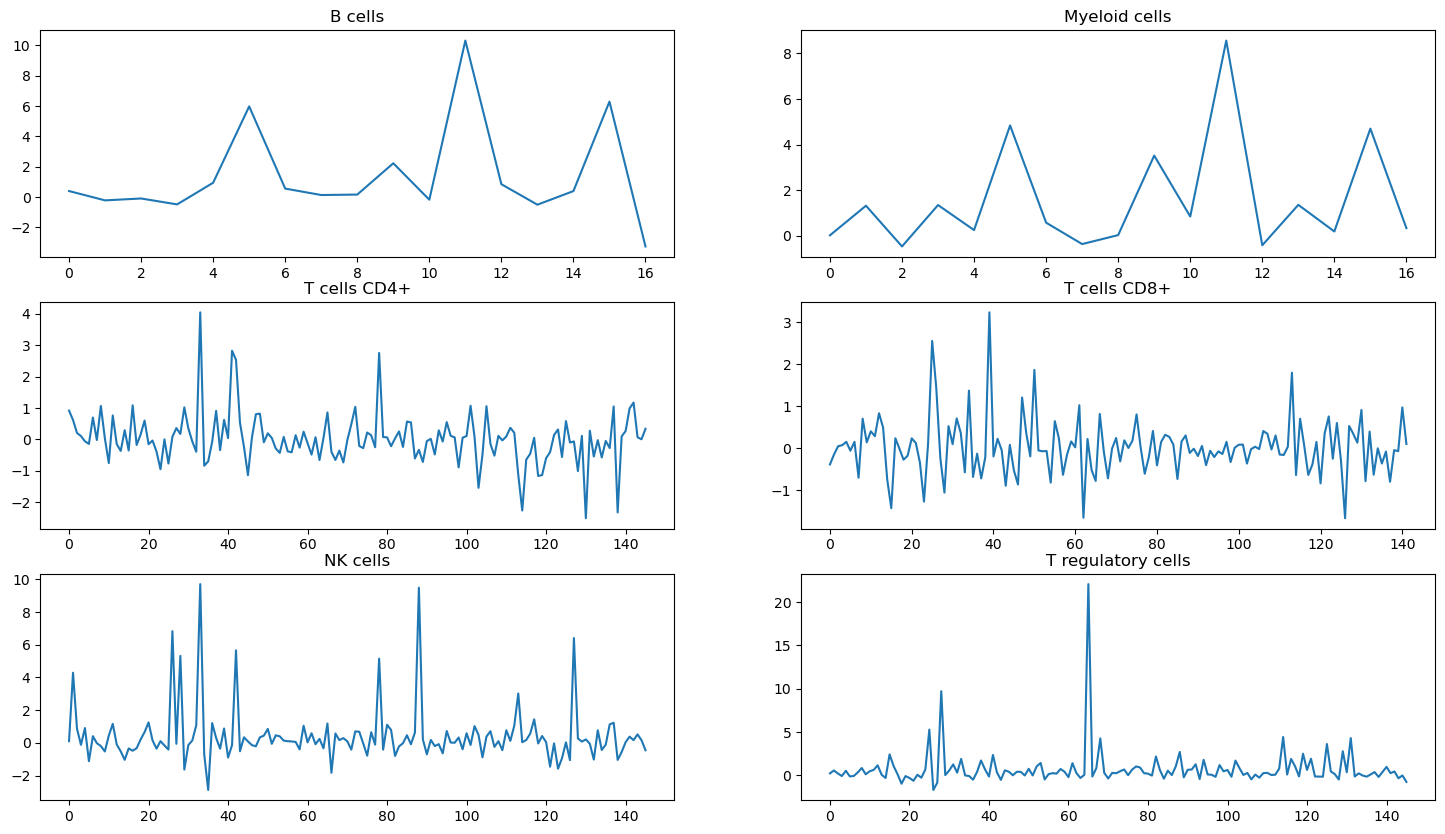

In [36]:
fig, ax = plt.subplots(3, 2)

for i in df.columns[5:6]:
    ax[0, 0].plot(np.arange(len(b_df[i].values)), b_df[i].values)
    ax[1, 0].plot(np.arange(len(t_cd4_df[i].values)), t_cd4_df[i].values)
    ax[2, 0].plot(np.arange(len(nk_df[i].values)), nk_df[i].values)
    ax[0, 1].plot(np.arange(len(m_df[i].values)), m_df[i].values)
    ax[1, 1].plot(np.arange(len(t_cd8_df[i].values)), t_cd8_df[i].values)
    ax[2, 1].plot(np.arange(len(t_r_df[i].values)), t_r_df[i].values)
    
ax[0, 0].set_title('B cells')
ax[1, 0].set_title('T cells CD4+')
ax[2, 0].set_title('NK cells')
ax[0, 1].set_title('Myeloid cells')
ax[1, 1].set_title('T cells CD8+')
ax[2, 1].set_title('T regulatory cells');

Первая 1000 генов:

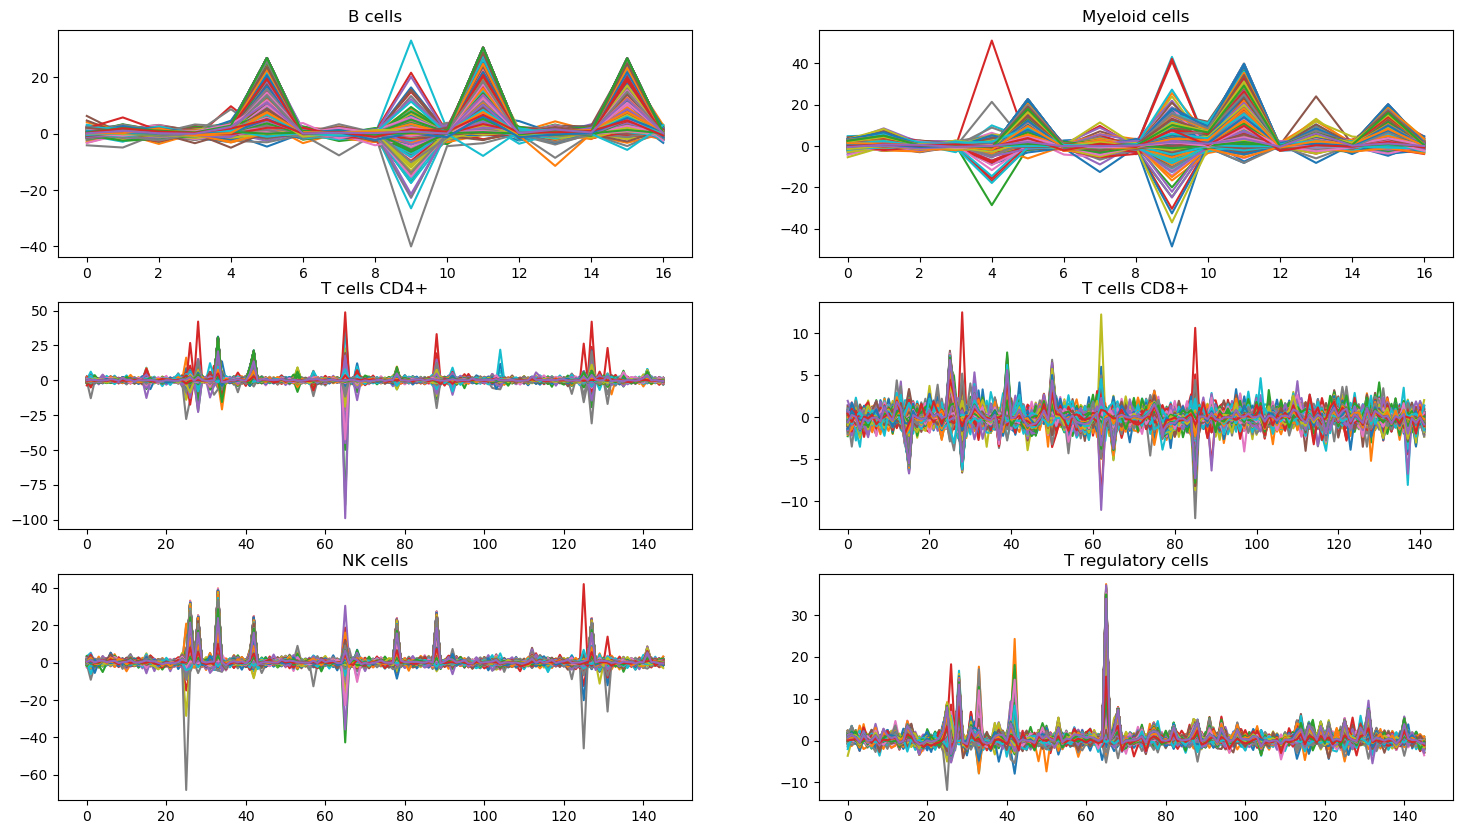

In [97]:
fig, ax = plt.subplots(3, 2)

for i in df.columns[5:1000]:
    ax[0, 0].plot(np.arange(len(b_df[i].values)), b_df[i].values)
    ax[1, 0].plot(np.arange(len(t_cd4_df[i].values)), t_cd4_df[i].values)
    ax[2, 0].plot(np.arange(len(nk_df[i].values)), nk_df[i].values)
    ax[0, 1].plot(np.arange(len(m_df[i].values)), m_df[i].values)
    ax[1, 1].plot(np.arange(len(t_cd8_df[i].values)), t_cd8_df[i].values)
    ax[2, 1].plot(np.arange(len(t_r_df[i].values)), t_r_df[i].values)
    
ax[0, 0].set_title('B cells')
ax[1, 0].set_title('T cells CD4+')
ax[2, 0].set_title('NK cells')
ax[0, 1].set_title('Myeloid cells')
ax[1, 1].set_title('T cells CD8+')
ax[2, 1].set_title('T regulatory cells');


Последняя 1000 генов

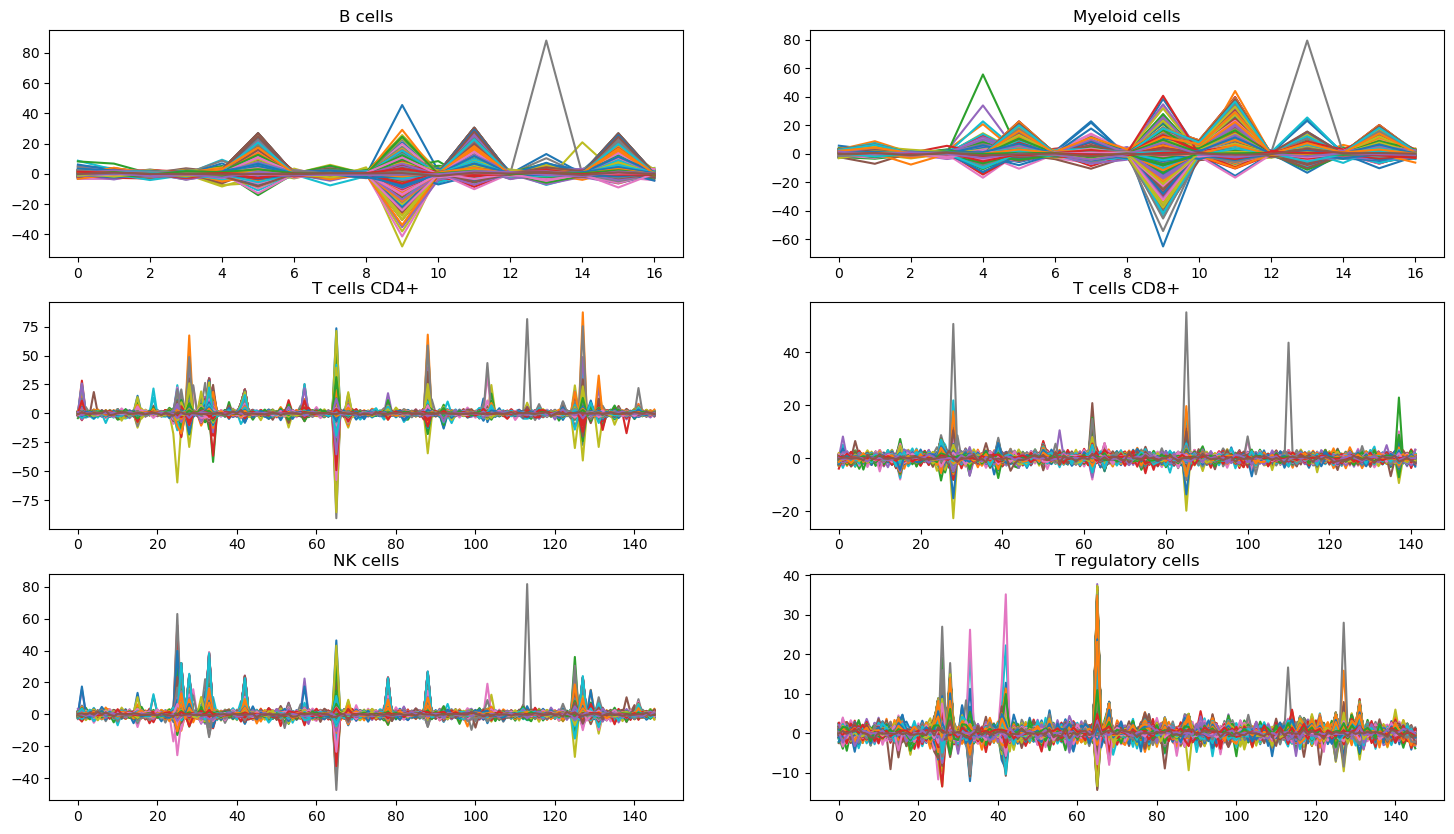

In [99]:
fig, ax = plt.subplots(3, 2)

for i in df.columns[17000:]:
    ax[0, 0].plot(np.arange(len(b_df[i].values)), b_df[i].values)
    ax[1, 0].plot(np.arange(len(t_cd4_df[i].values)), t_cd4_df[i].values)
    ax[2, 0].plot(np.arange(len(nk_df[i].values)), nk_df[i].values)
    ax[0, 1].plot(np.arange(len(m_df[i].values)), m_df[i].values)
    ax[1, 1].plot(np.arange(len(t_cd8_df[i].values)), t_cd8_df[i].values)
    ax[2, 1].plot(np.arange(len(t_r_df[i].values)), t_r_df[i].values)
    
ax[0, 0].set_title('B cells')
ax[1, 0].set_title('T cells CD4+')
ax[2, 0].set_title('NK cells')
ax[0, 1].set_title('Myeloid cells')
ax[1, 1].set_title('T cells CD8+')
ax[2, 1].set_title('T regulatory cells');

Определим на какие типы клеток похожи наши таргеты

In [7]:
b_drugs = b_df['sm_name'].unique()
m_drugs = m_df['sm_name'].unique()
print(f'Лекарства по B cell и Myeloid cells совпадают: {(b_drugs == m_drugs).any()}')

Лекарства по B cell и Myeloid cells совпадают: True


In [102]:
sim_df = df.loc[df['sm_name'].isin(b_drugs)]
sim_df[sim_df['sm_name'] == b_drugs[0]]

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
8,B cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.394173,-0.153824,0.178232,0.566241,0.391377,...,-1.052302,-1.176587,-1.220291,-0.278944,-0.095066,1.101790,0.061803,1.406335,-0.264996,-0.119743
9,Myeloid cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.025146,0.316388,1.366885,1.301593,2.317619,...,-0.902546,-1.445523,0.794772,0.428973,0.605834,0.271988,0.492231,0.354721,1.471559,-0.259483
10,NK cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.861487,-0.112313,-0.355217,0.719999,0.655865,...,0.035687,0.138060,-0.776619,-0.109832,-0.189906,0.753086,0.190892,-0.141699,-0.756510,-0.076934
11,T cells CD4+,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.206471,0.014638,-0.247518,0.430198,0.103020,...,-0.018902,-1.013426,-1.196254,-0.983257,1.097309,-0.090271,-1.293485,0.118196,-0.120892,-0.411331
12,T cells CD8+,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.046959,-0.346839,0.023478,0.485611,0.005066,...,0.017437,0.537964,-0.219895,0.376181,0.706930,-0.554368,0.035559,-0.189976,-0.145465,0.109084
13,T regulatory cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.210456,0.842411,0.428241,0.556238,0.792801,...,-1.184522,0.020869,0.337240,0.045808,0.318908,0.165729,1.345535,0.370730,-0.640314,-0.135686


In [69]:
sim_df[sim_df['sm_name'] == b_drugs[0]].iloc[[5]]

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
13,T regulatory cells,Idelalisib,LSM-1205,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...,False,0.210456,0.842411,0.428241,0.556238,0.792801,...,-1.184522,0.020869,0.33724,0.045808,0.318908,0.165729,1.345535,0.37073,-0.640314,-0.135686


In [75]:
(sim_df[sim_df['sm_name'] == b_drugs[0]].iloc[[5]][gene_names].values[0][:1000]).shape

(1000,)

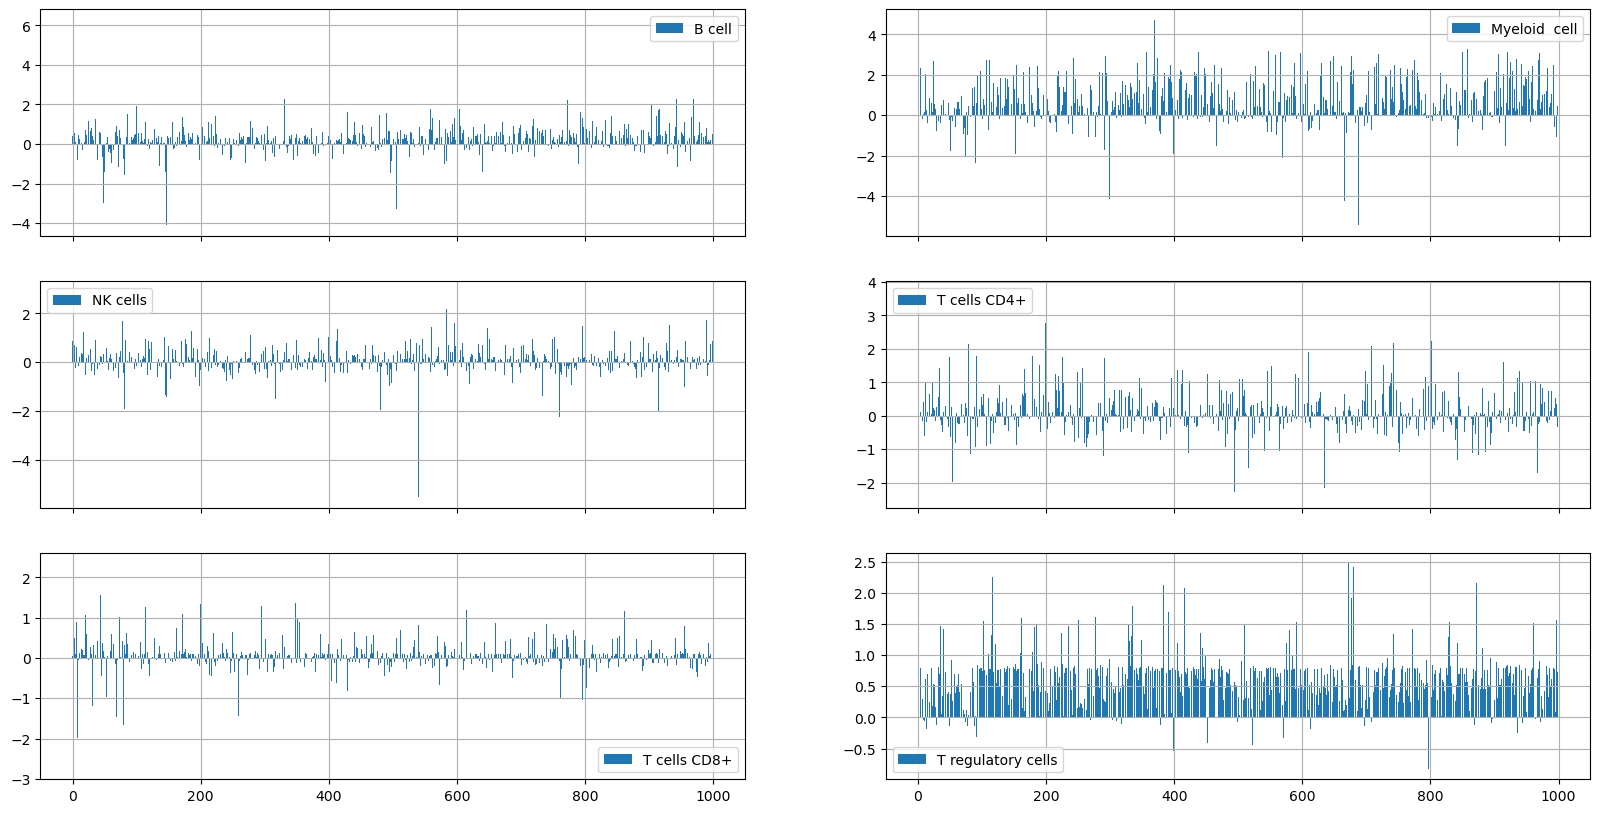

In [85]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10), sharex=True)

ax[0, 0].bar(x=np.arange(1000),
    height=sim_df[sim_df['sm_name'] == b_drugs[0]].iloc[[0]][gene_names].values[0][:1000], label='B cell')
ax[0, 1].bar(x=np.arange(1000),
    height=sim_df[sim_df['sm_name'] == b_drugs[0]].iloc[[1]][gene_names].values[0][:1000], label='Myeloid  cell')

ax[1, 0].bar(x=np.arange(1000),
    height=sim_df[sim_df['sm_name'] == b_drugs[0]].iloc[[2]][gene_names].values[0][:1000], label='NK cells')
ax[1, 1].bar(x=np.arange(1000),
    height=sim_df[sim_df['sm_name'] == b_drugs[0]].iloc[[3]][gene_names].values[0][:1000], label='T cells CD4+')

ax[2, 0].bar(x=np.arange(1000),
    height=sim_df[sim_df['sm_name'] == b_drugs[0]].iloc[[4]][gene_names].values[0][:1000], label='T cells CD8+')
ax[2, 1].bar(x=np.arange(1000),
    height=sim_df[sim_df['sm_name'] == b_drugs[0]].iloc[[5]][gene_names].values[0][:1000], label='T regulatory cells')

ax[0, 0].legend(), ax[0, 0].grid(),
ax[0, 1].legend(), ax[0, 1].grid(),
ax[1, 0].legend(), ax[1, 0].grid(),
ax[1, 1].legend(), ax[1, 1].grid(),
ax[2, 0].legend(), ax[2, 0].grid(),
ax[2, 1].legend(), ax[2, 1].grid();

In [115]:
sim_df[sim_df['sm_name'] == b_drugs[0]]['cell_type'].values

array(['B cells', 'Myeloid cells', 'NK cells', 'T cells CD4+',
       'T cells CD8+', 'T regulatory cells'], dtype=object)

In [108]:
sim_df[sim_df['sm_name'] == b_drugs[0]][gene_names].loc[8].values

array([ 0.39417333, -0.15382374,  0.17823169, ...,  1.40633482,
       -0.26499553, -0.11974328])

In [122]:
from sklearn.metrics import pairwise

cosine = pairwise.cosine_similarity(sim_df[sim_df['sm_name'] == b_drugs[0]][gene_names].values)

cosine_df = pd.DataFrame(cosine, columns=sim_df[sim_df['sm_name'] == b_drugs[0]]['cell_type'].values, index=sim_df[sim_df['sm_name'] == b_drugs[0]]['cell_type'].values)

cosine_df

cosine_df['B cells'].sort_values()[[-2]]
cosine_df['Myeloid cells'].sort_values()[[-2]]

,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells
B cells,1.000000,0.198450,0.205964,0.277233,0.106609,0.212525
Myeloid cells,0.198450,1.000000,0.098321,0.098221,0.097760,0.385118
NK cells,0.205964,0.098321,1.000000,0.229820,0.089889,0.126046
T cells CD4+,0.277233,0.098221,0.229820,1.000000,0.133512,0.153232
T cells CD8+,0.106609,0.097760,0.089889,0.133512,1.000000,0.129071
T regulatory cells,0.212525,0.385118,0.126046,0.153232,0.129071,1.000000


In [137]:
cosine_df['B cells'].sort_values()[[-2]]
cosine_df['Myeloid cells'].sort_values()[[-2]]

T regulatory cells    0.385118
Name: Myeloid cells, dtype: float64

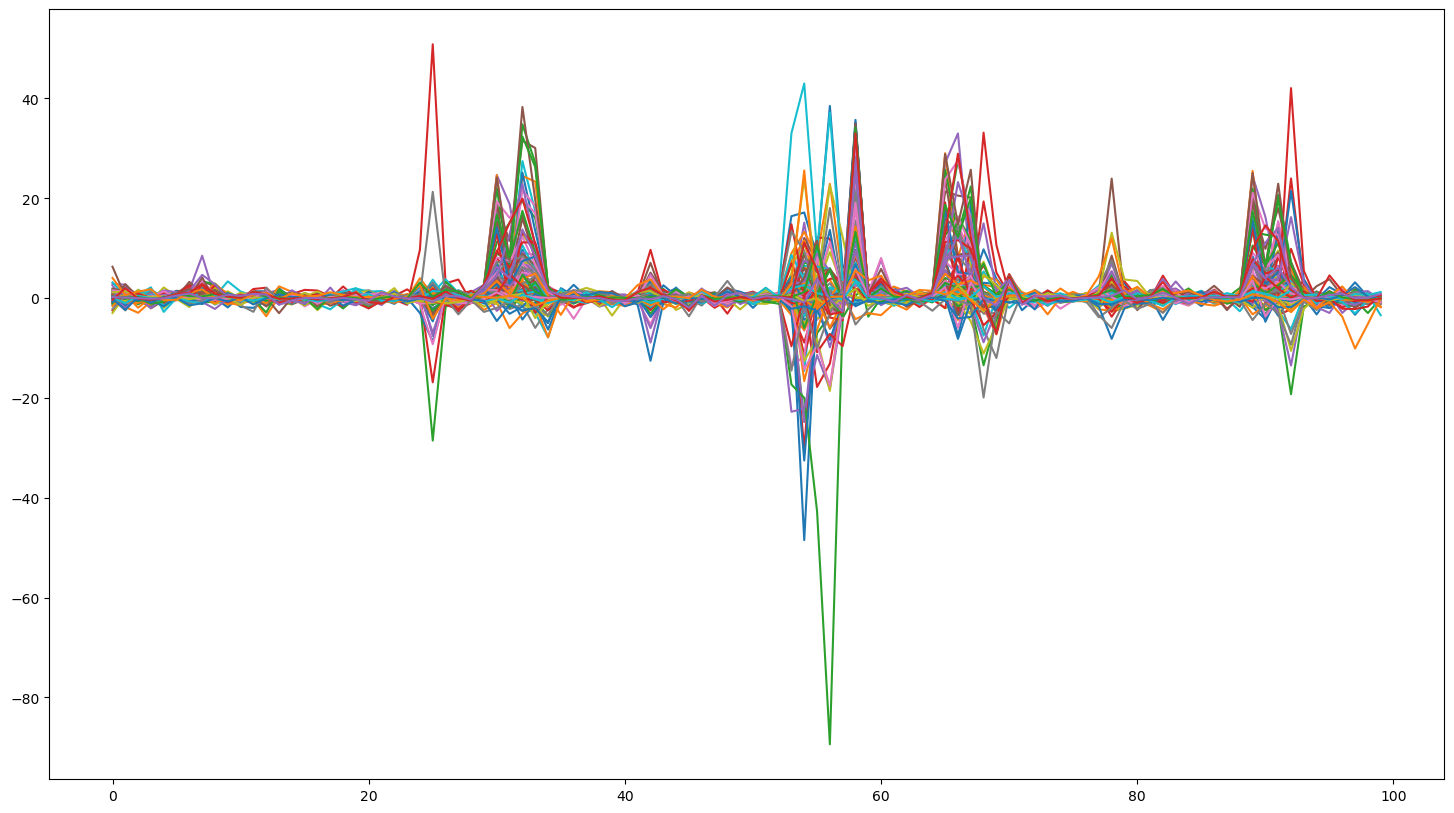

In [138]:
for i in df.columns[5:100]:
    plt.plot(np.arange(len(sim_df[i].values)), sim_df[i].values)

In [ ]:
fig, ax = plt.subplots(3, 2)

for i in df.columns[5:100]:
    ax[0, 0].plot(np.arange(len(b_df[i].values)), b_df[i].values)
    ax[1, 0].plot(np.arange(len(t_cd4_df[i].values)), t_cd4_df[i].values)
    ax[2, 0].plot(np.arange(len(nk_df[i].values)), nk_df[i].values)
    ax[0, 1].plot(np.arange(len(m_df[i].values)), m_df[i].values)
    ax[1, 1].plot(np.arange(len(t_cd8_df[i].values)), t_cd8_df[i].values)
    ax[2, 1].plot(np.arange(len(t_r_df[i].values)), t_r_df[i].values)
    
ax[0, 0].set_title('B cells')
ax[1, 0].set_title('T cells CD4+')
ax[2, 0].set_title('NK cells')
ax[0, 1].set_title('Myeloid cells')
ax[1, 1].set_title('T cells CD8+')
ax[2, 1].set_title('T regulatory cells');

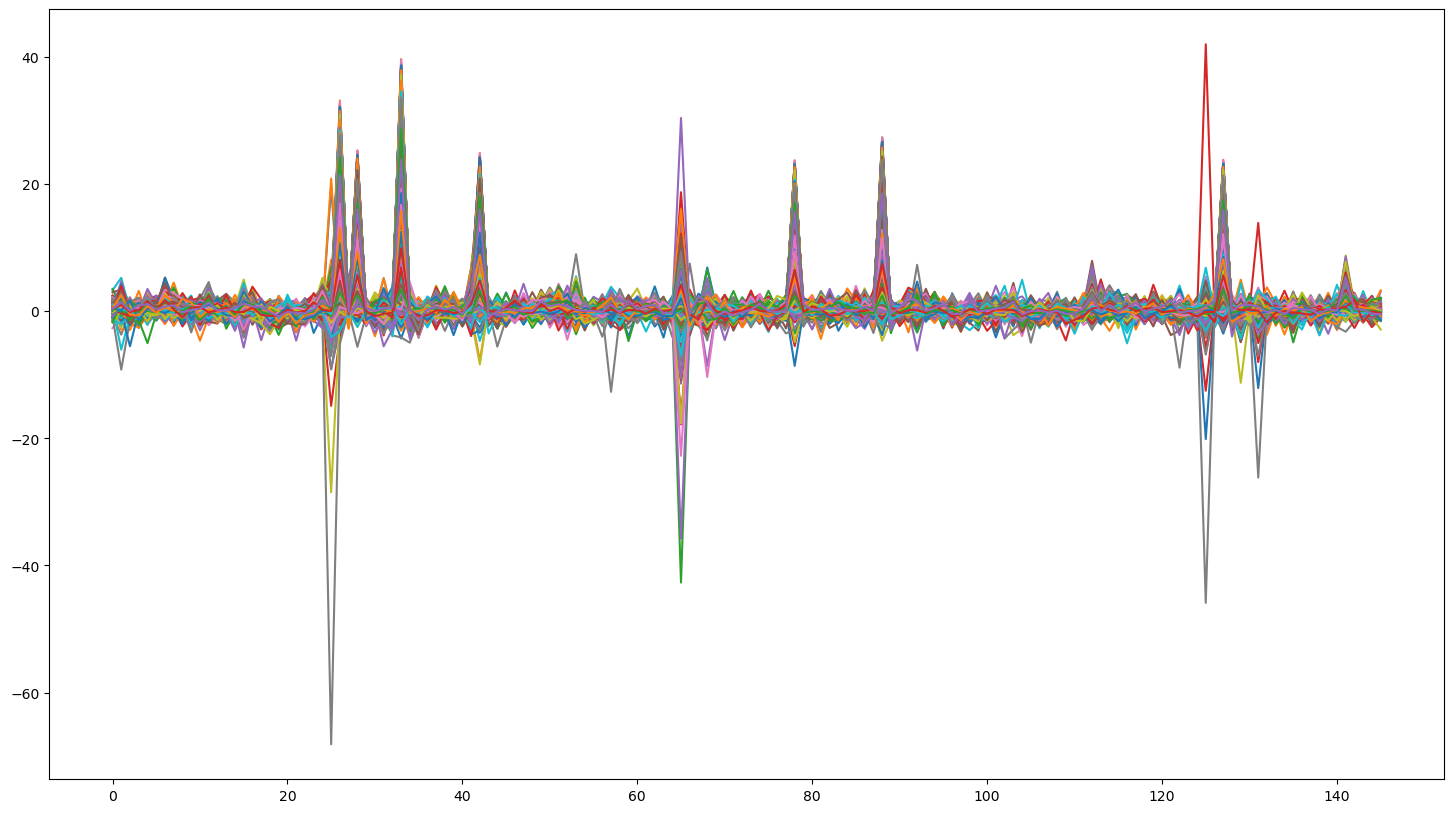

In [13]:
for i in nk_df.columns[5:1000]:
    
    plt.plot(np.arange(146), nk_df[i].values)


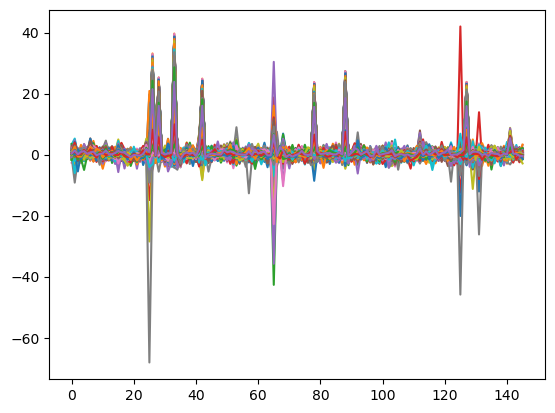

In [6]:
for i in m_df.columns[5:1000]:
    
    plt.plot(np.arange(146), nk_df[i].values)

***

## Какие клатки похожи на какие?

In [720]:
df = de_train.copy()
df.head(2)
#sm_dict = dict(zip(df['sm_name'].unique(), np.linspace(1, 10, len(df['sm_name'].unique()))))
#cell_dict = dict(zip(df['cell_type'].unique(), np.linspace(1, 10, len(df['cell_type'].unique()))))

sm_dict = dict(zip(df['sm_name'].unique(), np.arange(1, len(df['sm_name'].unique()) + 1)))
cell_dict = dict(zip(df['cell_type'].unique(), np.arange(1, len(df['cell_type'].unique()) + 1)))


In [688]:
df['sm_name'] = df['sm_name'].apply(lambda x: x.replace('Proscillaridin A;Proscillaridin-A', 'Proscillaridin-A'))
df['sm_lincs_id'] = df['sm_lincs_id'].apply(lambda x: x.replace('LSM-1476;', ''))
df['sm_lincs_id'] = df['sm_lincs_id'].apply(lambda x: x.replace('LSM-', ''))
df['sm_lincs_id'] = df['sm_lincs_id'].apply(lambda x: x[:-3])

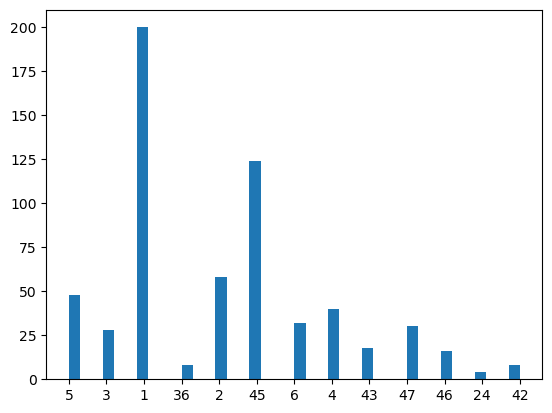

In [704]:
plt.hist(df['sm_lincs_id'], bins=40,);

In [721]:
df['sm_name_1'] = df['sm_name'].apply(lambda x: sm_dict[x])

In [732]:
df

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,sm_name_1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755,1
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887,1
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365,1
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024,1
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951,145
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760,146
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082,146
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112,146


In [722]:
nk_df = df[df['cell_type'] == 'NK cells']
t_cd4_df = df[df['cell_type'] == 'T cells CD4+']
t_cd8_df = df[df['cell_type'] == 'T cells CD8+']
t_r_df = df[df['cell_type'] == 'T regulatory cells']
b_df = df[df['cell_type'] == 'B cells']
m_df = df[df['cell_type'] == 'Myeloid cells']

print(f"Shape of NK cells data: {nk_df.shape}")
print(f"Shape of T cells CD4+ data: {t_cd4_df.shape}")
print(f"Shape of T cells CD8+ data: {t_cd8_df.shape}")
print(f"Shape of T regulatory cells data: {t_r_df.shape}")
print(f"Shape of B cells data: {b_df.shape}")
print(f"Shape of Myeloid cells data: {m_df.shape}")

Shape of NK cells data: (146, 18217)
Shape of T cells CD4+ data: (146, 18217)
Shape of T cells CD8+ data: (142, 18217)
Shape of T regulatory cells data: (146, 18217)
Shape of B cells data: (17, 18217)
Shape of Myeloid cells data: (17, 18217)


In [767]:
temp = np.zeros_like(df['A1BG'])
temp[temp == 0] = df['A1BG'].std()

In [779]:
def filter_1(data, n=1):
    for col in data.columns:
        data[col] = data[col].apply(lambda x: x if x > data[col].std() * n else 0)
    return data

df_new = filter_1(df.iloc[:,5:])

In [770]:
temp_2 = df['A1BG'].apply(lambda x: x if x > df['A1BG'].std() else 0)

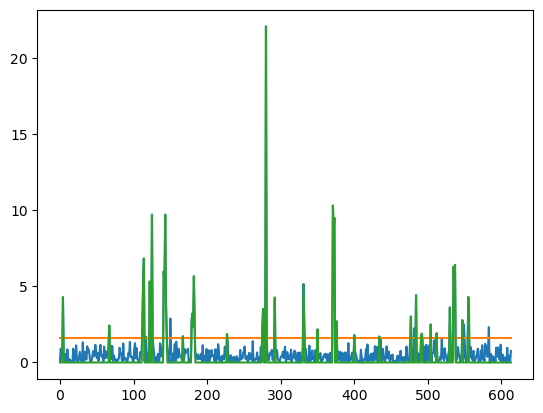

In [771]:
plt.plot(abs(df['A1BG']))
plt.plot(temp)
plt.plot(temp_2)

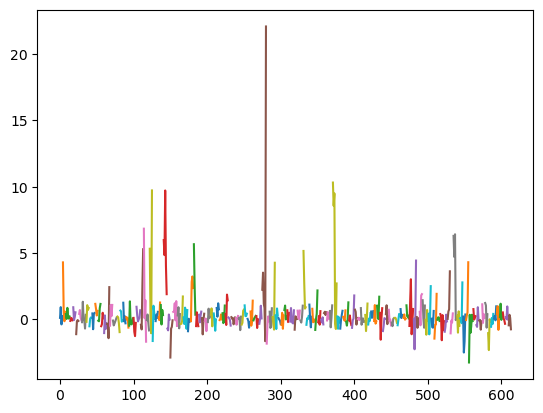

In [745]:
for i in df['sm_name_1'].unique():
    plt.plot(df[df['sm_name_1'] == i]['A1BG'])

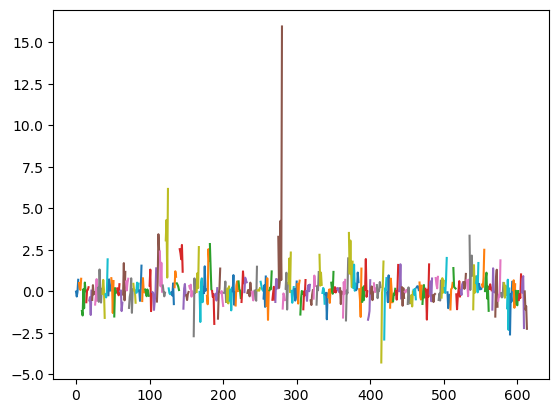

In [744]:
for i in df['sm_name_1'].unique():
    plt.plot(df[df['sm_name_1'] == i]['ZW10'])

In [729]:
nk_df['sm_name_1'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146])

In [731]:
df[df['sm_name_1'] == '3']

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,sm_name_1


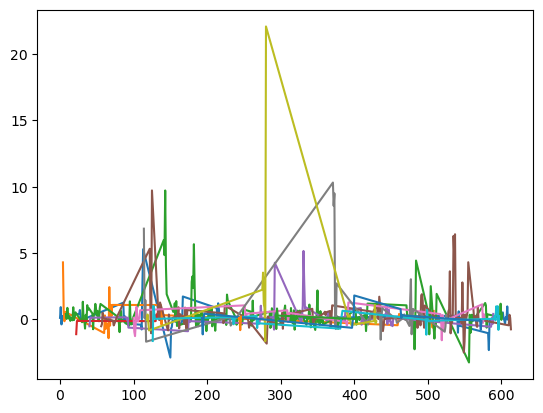

In [713]:
for i in nk_df['sm_lincs_id'].unique():
    plt.plot(df[df['sm_lincs_id'] == i]['A1BG'])

In [706]:
nk_df.iloc[:,5:].values

array([[ 0.10472047, -0.07752421, -1.62559604, ...,  0.03412678,
         0.22137655,  0.36875538],
       [ 4.2906521 , -0.06386359, -0.01744324, ...,  0.11236464,
        -0.12219311,  0.67662888],
       [ 0.86148677, -0.11231322, -0.35521712, ..., -0.14169934,
        -0.75651001, -0.07693369],
       ...,
       [ 0.51784905,  0.93518045, -0.6873407 , ...,  0.0062    ,
         0.15266354,  1.06804517],
       [ 0.16175982, -0.1118389 ,  0.4352723 , ...,  0.69789718,
        -0.12016755, -0.82747285],
       [-0.45554949,  0.18818145,  0.59573378, ..., -0.23164198,
         1.02399363, -0.06476045]])

In [363]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

model = LinearRegression().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'MAE_train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MAE_test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE_train: {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE_test: {mean_squared_error(y_test, y_test_pred)}')

MAE_train: 0.8577787209627721
MAE_test: 0.7299198623613803
MSE_train: 3.027957400651752
MSE_test: 0.9751729303182122


In [349]:
model.coef_

array([[ 0.1189257 , -0.02123414]])

In [356]:
model_1 = LinearRegression().fit(X.values, y.values)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'MAE_train: {mean_absolute_error(y_train, y_train_pred)}')
print(f'MAE_test: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE_train: {mean_squared_error(y_train, y_train_pred)}')
print(f'MSE_test: {mean_squared_error(y_test, y_test_pred)}')
model_1.coef_

MAE_train: 0.7977768996701963
MAE_test: 1.5887836973548817
MSE_train: 2.6102448614842513
MSE_test: 2.5242336369806484


array([[ 0.09936948, -0.022432  ]])

In [191]:
from sklearn.model_selection import train_test_split

df_sm = df.drop(['cell_type', 'sm_lincs_id', 'SMILES', 'control', 'sm_name'], axis=1)

new_y = np.zeros_like(y)
sm_dict = dict(zip(set(y), range(len(set(y)))))

for i in range(len(y)):
    new_y[i] = sm_dict[y[i]]
    
X = df.drop(['cell_type', 'sm_lincs_id', 'SMILES', 'control', 'sm_name'], axis=1)
y = df['sm_name']

X_train, X_valid, y_train, y_valid = train_test_split(X.values, new_y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import f1_score

# Подготовом сеты данных
train_dataset = lgb.Dataset(X_train, y_train)
test_dataset = lgb.Dataset(X_valid, y_valid)

# потренируем модель
booster = lgb.train({"objective": "multiclass", "num_class":len(y.unique()), "verbosity": -1},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=200)

# Сделаем предсказания
train_preds = booster.predict(X_train)
valid_preds = booster.predict(X_valid)
set_preds = booster.predict(X)

train_preds = np.argmax(train_preds, axis=1)
valid_preds = np.argmax(valid_preds, axis=1)
set_preds = np.argmax(set_preds, axis=1)

np.argmax(booster.predict(X.iloc[4]), 1)
res = dict((v,k) for k,v in sm_dict.items())
res[65]

In [239]:
adata_obs_meta

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
0,000006a87ba75b72,library_4,plate_4,F7,F,7,PBMC,donor_2,T cells CD4+,LSM-4944,MLN 2238,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,1.0,24,False
1,0000233976e3cd37,library_0,plate_3,D4,D,4,PBMC,donor_1,T cells CD4+,LSM-46203,BMS-265246,CCCCOc1c(C(=O)c2c(F)cc(C)cc2F)cnc2[nH]ncc12,1.0,24,False
2,0001533c5e876362,library_2,plate_0,B11,B,11,PBMC,donor_0,T regulatory cells,LSM-45663,Resminostat,CN(C)Cc1ccc(S(=O)(=O)n2ccc(/C=C/C(=O)NO)c2)cc1,1.0,24,False
3,00022f989630d14b,library_35,plate_2,E6,E,6,PBMC,donor_0,T cells CD4+,LSM-43216,FK 866,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,1.0,24,False
4,0002560bd38ce03e,library_22,plate_4,B6,B,6,PBMC,donor_2,T cells CD4+,LSM-1099,Nilotinib,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,1.0,24,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240085,ffff28f274e983df,library_27,plate_0,G12,G,12,PBMC,donor_0,NK cells,LSM-3349,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,1.0,24,False
240086,ffff32893af5befb,library_31,plate_4,E7,E,7,PBMC,donor_2,T cells CD4+,LSM-2287,Midostaurin,CO[C@@H]1[C@H](N(C)C(=O)c2ccccc2)C[C@H]2O[C@]1...,1.0,24,False
240087,ffff6c3e0a7b05ad,library_38,plate_1,C5,C,5,PBMC,donor_2,NK cells,LSM-45786,BAY 87-2243,Cc1cc(-c2nc(-c3ccc(OC(F)(F)F)cc3)no2)nn1Cc1ccn...,1.0,24,False
240088,ffff8e571c7e8cb0,library_28,plate_5,B1,B,1,PBMC,donor_1,B cells,LSM-43181,Belinostat,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,0.1,24,True


In [ ]:
gene_names = de_train.columns[5:]
gene_group = de_train.groupby('cell_type')[gene_names].mean().reset_index()

b_cells_coef = gene_group.iloc[0] / gene_group.sum()
myeloid_cells_coef = gene_group.iloc[1] / gene_group.sum()

b_train = de_train.groupby('sm_name')[gene_names].mean().reset_index() * b_cells_coef
myeloid_train = de_train.groupby('sm_name')[gene_names].mean().reset_index() * myeloid_cells_coef

b_cell_sample = id_map[id_map['cell_type'] == 'B cells']
myeloid_cell_sample = id_map[id_map['cell_type'] == 'Myeloid cells']

sample = pd.concat([
    b_cell_sample.merge(b_train, on='sm_name', how='left'), 
    myeloid_cell_sample.merge(myeloid_train, on='sm_name', how='left')], axis=0)

sample = sample.drop(['cell_type', 'sm_name'], axis=1)

In [111]:
sample.to_csv('submission.csv', index=False)

In [115]:
pd.read_csv('submission.csv')

,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.099893,-0.027272,-0.774249,0.821812,0.275410,0.243175,0.008552,0.049844,-0.749450,...,-0.682501,-0.396681,-0.074171,0.166738,0.114959,0.182695,0.266521,0.295874,-0.040651,-0.148988
1,1,-0.027042,0.001774,-0.152250,-0.070382,0.082435,0.086938,-0.010954,0.005648,0.271373,...,0.382043,0.054525,0.021656,-0.089872,0.044785,-0.014379,0.067912,-0.124355,0.012591,0.025167
2,2,0.135738,0.078246,-0.201363,-0.027517,0.158613,0.387594,0.051293,0.044774,-0.103556,...,0.165436,-0.103508,-0.006885,0.264491,0.034569,0.071429,0.153815,-0.047643,-0.025140,0.196532
3,3,-0.010357,0.129446,-0.233765,0.135129,-0.006669,0.013345,-0.011868,0.190723,-0.016749,...,-0.089430,0.037551,-0.047152,0.198801,0.003894,0.031490,0.000223,0.139910,-0.014389,-0.044904
4,4,0.080754,-0.066910,-0.296683,0.149611,-0.001257,0.061783,-0.015574,0.038356,-0.205885,...,-0.624950,-0.051051,0.029448,-0.215859,0.010607,0.101737,-0.094264,0.426026,0.004142,-0.021385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,-0.002299,-0.231458,-0.919729,-0.153612,0.055543,-0.198833,0.032114,0.027152,-0.030219,...,-0.105657,0.005003,-0.552201,0.007293,-0.083175,-0.072014,-0.058017,0.002708,0.035367,0.058643
251,251,0.071125,-0.158138,0.428921,0.137932,0.146518,0.090070,-0.201706,-0.045119,-0.034588,...,-0.021602,0.010111,0.218076,-0.012292,0.090167,-0.022015,0.104993,-0.202731,-0.064556,-0.051102
252,252,-0.036818,0.181243,-1.354369,-0.048798,0.010956,-0.101196,-0.228552,-0.078443,0.011120,...,-0.040979,-0.004443,0.777329,-0.012043,0.032585,-0.021074,0.085073,-0.108479,0.085032,-0.088946
253,253,0.028453,0.005014,1.812997,-0.002953,0.173880,-0.085194,0.545533,0.148111,0.404640,...,-0.298476,-0.047705,-0.591147,0.007709,-0.239931,0.087912,0.058833,-0.120128,-0.007765,0.062439


In [133]:
id_map

,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867
...,...,...,...
250,250,Myeloid cells,Vandetanib
251,251,Myeloid cells,Vanoxerine
252,252,Myeloid cells,Vardenafil
253,253,Myeloid cells,Vorinostat


In [145]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [136]:
sm_name = de_train.groupby('sm_name')[gene_names].mean().reset_index()

In [147]:

sm_name = de_train.groupby('sm_name')[gene_names].mean().reset_index()
sample = id_map.merge(sm_name, on='sm_name', how='left')
sample = sample.drop(['cell_type', 'sm_name'], axis=1)
sample.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv')

,id,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,0.210903,-0.876761,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,1,-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,0.023898,0.317472,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,2,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,0.189453,-0.121147,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,3,-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,0.806999,-0.019594,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,4,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,0.162294,-0.240859,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,0.155058,-0.130232,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
251,251,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,-0.257659,-0.149061,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
252,252,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,-0.447963,0.047921,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
253,253,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,0.845815,1.743839,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


In [139]:
sample

,id,cell_type,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...,0.300267,-0.112432,0.413144,1.468632,0.733237,0.722462,0.125359,...,-0.769578,-0.690020,0.303616,0.260685,0.555278,0.837875,0.444535,0.432414,-0.219858,0.551906
1,1,B cells,ABT-199 (GDC-0199),-0.081286,0.007314,0.081242,-0.125777,0.219469,0.258288,-0.160568,...,0.430786,0.094845,-0.088646,-0.140509,0.216322,-0.065943,0.113272,-0.181743,0.068095,-0.093228
2,2,B cells,ABT737,0.408012,0.322574,0.107448,-0.049174,0.422284,1.151523,0.751861,...,0.186543,-0.180051,0.028183,0.413515,0.166978,0.327588,0.256550,-0.069630,-0.135967,-0.728025
3,3,B cells,AMD-070 (hydrochloride),-0.031131,0.533648,0.124738,0.241484,-0.017756,0.039647,-0.173965,...,-0.100840,0.065319,0.193013,0.310814,0.018807,0.144418,0.000372,0.204476,-0.077820,0.166340
4,4,B cells,AT 7867,0.242736,-0.275840,0.158312,0.267365,-0.003346,0.183553,-0.228290,...,-0.704684,-0.088803,-0.120544,-0.337481,0.051235,0.466585,-0.157225,0.622629,0.022401,0.079217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,250,Myeloid cells,Vandetanib,-0.006076,-0.672747,-0.230338,-0.492947,0.109427,-0.528983,0.030436,...,0.113566,-0.056856,-0.375688,-0.098679,-0.203246,-0.313355,0.105695,-0.004788,0.135301,0.254045
251,251,Myeloid cells,Vanoxerine,0.188002,-0.459637,0.107419,0.442630,0.288657,0.239626,-0.191168,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
252,252,Myeloid cells,Vardenafil,-0.097319,0.526795,-0.339189,-0.156595,0.021584,-0.269225,-0.216612,...,0.044047,0.050485,0.528853,0.162957,0.079624,-0.091698,-0.154987,0.191808,0.325303,-0.385319
253,253,Myeloid cells,Vorinostat,0.075208,0.014575,0.454048,-0.009477,0.342563,-0.226654,0.517033,...,0.320819,0.542119,-0.402185,-0.104306,-0.586294,0.382534,-0.107183,0.212404,-0.029705,0.270488


In [142]:
sample[sample['sm_name'] == 'Vanoxerine']

,id,cell_type,sm_name,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
124,124,B cells,Vanoxerine,0.188002,-0.459637,0.107419,0.44263,0.288657,0.239626,-0.191168,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
251,251,Myeloid cells,Vanoxerine,0.188002,-0.459637,0.107419,0.44263,0.288657,0.239626,-0.191168,...,0.023219,-0.114899,0.148367,0.166318,0.220331,-0.095794,-0.191277,0.358461,-0.246971,-0.221379
